# Power integrity analysis
This example shows how to use the Ansys Electronics Database (EDB) for power integrity analysis. The
EDB is loaded into HFSS 3D Layout for analysis and postprocessing.

- Set up EDB consists of these steps:

    - Assign S-parameter model to components.
    - Create pin groups.
    - Create ports.
    - Create SIwave SYZ analysis.
    - Create cutout.

- Import EDB into HFSS 3D Layout:

    - Analyze.
    - Plot ``$Z_{11}$``.

Keywords: **HFSS 3D Layout**, **power integrity**.

## Perform imports and define constants
Import the required packages

In [1]:
import json
import os
import tempfile
import time

import ansys.aedt.core
from ansys.aedt.core.examples.downloads import download_file

Define constants.

In [2]:
AEDT_VERSION = "2025.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [3]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

Download the example PCB data.

In [4]:
aedb = download_file(source="edb/ANSYS-HSD_V1.aedb", local_path=temp_folder.name)
_ = download_file(
    source="touchstone",
    name="GRM32_DC0V_25degC_series.s2p",
    local_path=temp_folder.name,
)

## Create configuration file
This example uses a configuration file to set up the layout for analysis.
Initialize and create an empty dictionary to host all configurations.

In [5]:
cfg = dict()

Assigns S-parameter models to capacitors.
The first step is to use the "general" key to specify where the S-parameter files can be found.

In [6]:
cfg["general"] = {"s_parameter_library": os.path.join(temp_folder.name, "touchstone")}

## Assign model to capactitors
The model ``GRM32_DC0V_25degC_series.s2p`` is assigned to capacitors C3 and C4, which share the same component part number.
When "apply_to_all" is ``True``, all components having the part number "CAPC3216X180X20ML20" are assigned the S-parameter model.

In [7]:
cfg["s_parameters"] = [
    {
        "name": "GRM32_DC0V_25degC_series",
        "component_definition": "CAPC0603X33X15LL03T05",
        "file_path": "GRM32_DC0V_25degC_series.s2p",
        "apply_to_all": False,
        "components": ["C110", "C206"],
        "reference_net": "GND",
        "reference_net_per_component": {"C110": "GND"},
    }
]

## Create pin groups
Pins can be grouped explicitly by the pin name, or pin groups can be assigned by net name using the ''net'' key.
The following code combine the listed pins on component U2 into two pin groups using the ``net`` key.

In [8]:
cfg["pin_groups"] = [
    {
        "name": "PIN_GROUP_1",
        "reference_designator": "U1",
        "pins": ["AD14", "AD15", "AD16", "AD17"],
    },
    {"name": "PIN_GROUP_2", "reference_designator": "U1", "net": "GND"},
]

## Create ports
Create a circuit port between the two pin groups just created.

In [9]:
cfg["ports"] = [
    {
        "name": "port1",
        "reference_designator": "U1",
        "type": "circuit",
        "positive_terminal": {"pin_group": "PIN_GROUP_1"},
        "negative_terminal": {"pin_group": "PIN_GROUP_2"},
    }
]

## Create SIwave SYZ analysis setup
Both SIwave and HFSS can be used to run an analysis in the 3D Layout user interface.

In [10]:
cfg["setups"] = [
    {
        "name": "siwave_syz",
        "type": "siwave_syz",
        "pi_slider_position": 1,
        "freq_sweep": [
            {
                "name": "Sweep1",
                "type": "Interpolation",
                "frequencies": [
                    {
                        "distribution": "log scale",
                        "start": 1e6,
                        "stop": 1e9,
                        "samples": 20,
                    }
                ],
            }
        ],
    }
]

## Define cutout
Define the region of the PCB to be cut out for analysis.

In [11]:
cfg["operations"] = {
    "cutout": {
        "signal_list": ["1V0"],
        "reference_list": ["GND"],
        "extent_type": "ConvexHull",
        "expansion_size": 0.002,
        "use_round_corner": False,
        "output_aedb_path": "",
        "open_cutout_at_end": True,
        "use_pyaedt_cutout": True,
        "number_of_threads": 4,
        "use_pyaedt_extent_computing": True,
        "extent_defeature": 0,
        "remove_single_pin_components": False,
        "custom_extent": "",
        "custom_extent_units": "mm",
        "include_partial_instances": False,
        "keep_voids": True,
        "check_terminals": False,
        "include_pingroups": False,
        "expansion_factor": 0,
        "maximum_iterations": 10,
        "preserve_components_with_model": False,
        "simple_pad_check": True,
        "keep_lines_as_path": False,
    }
}

## Save configuration

Save the configuration file to a JSON file and apply it to layout data using the EDB.

In [12]:
pi_json = os.path.join(temp_folder.name, "pi.json")
with open(pi_json, "w") as f:
    json.dump(cfg, f, indent=4, ensure_ascii=False)

## Load configuration into EDB

Load the configuration into EDB from the JSON file.

In [13]:
edbapp = ansys.aedt.core.Edb(aedb, edbversion=AEDT_VERSION)
edbapp.configuration.load(config_file=pi_json)
edbapp.configuration.run()
edbapp.save()
edbapp.close()

C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\misc\decorators.py:55: UserWarning: Argument `edbversion` is deprecated for method `Edb`; use `version` instead.
  warnings.warn(
C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\generic\design_types.py:301: UserWarning: Your ANSYS AEDT version is eligible to gRPC version.You might consider switching to that version for better user experience.For more information please check this link: https://edb.docs.pyansys.com/version/dev/grpc_api/index.html
  warnings.warn(GRPC_GENERAL_WARNING, UserWarning)


PyEDB INFO: Star initializing Edb 12:09:14.830731


PyEDB INFO: Edb version 2025.2


PyEDB INFO: Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


PyEDB INFO: legacy v0.67.1


PyEDB INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyEDB INFO: Database ANSYS-HSD_V1.aedb Opened in 2025.2


PyEDB INFO: Cell main Opened


PyEDB INFO: Builder was initialized.


PyEDB INFO: open_edb completed in 9.0515 seconds.


PyEDB INFO: EDB initialization completed in 9.1151 seconds.


PyEDB INFO: Updating nets finished. Time lapse 0:00:00


PyEDB INFO: Updating components finished. Time lapse 0:00:00


PyEDB INFO: Creating pin groups finished. Time lapse 0:00:00.506597


PyEDB INFO: Placing sources finished. Time lapse 0:00:00


PyEDB INFO: Applying materials finished. Time lapse 0:00:00


PyEDB INFO: Updating stackup finished. Time lapse 0:00:00


PyEDB INFO: Applying padstack definitions and instances completed in 0.0000 seconds.


PyEDB INFO: Applying S-parameters finished. Time lapse 0:00:00.015999


PyEDB INFO: Applying package definitions finished. Time lapse 0:00:00


PyEDB INFO: Applying modeler finished. Time lapse 0:00:00


PyEDB INFO: Placing ports finished. Time lapse 0:00:00


PyEDB INFO: Placing terminals completed in 0.0000 seconds.


PyEDB INFO: Placing probes finished. Time lapse 0:00:00


PyEDB INFO: -----------------------------------------


PyEDB INFO: Trying cutout with (0.002)*(1000.0)mm expansion size


PyEDB INFO: -----------------------------------------


PyEDB INFO: Cutout Multithread started.


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Unexpected Value)
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='resistor_below', input_value=100, input_type=int])
  PydanticSerializationUnexpectedValue(Unexpected Value)
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='inductor_below', input_value=1, input_type=int])
  return self.__pydantic_serializer__.to_python(


PyEDB INFO: Net clean up Elapsed time: 0m 1sec


PyEDB INFO: Extent Creation Elapsed time: 0m 0sec


PyEDB INFO: 1310 Padstack Instances deleted. Elapsed time: 0m 1sec


PyEDB INFO: 265 Primitives deleted. Elapsed time: 0m 2sec


PyEDB INFO: 702 components deleted


PyEDB INFO: Cutout completed. Elapsed time: 0m 4sec


PyEDB INFO: EDB file save completed in 0.0812 seconds.


PyEDB INFO: Cutout completed in 1 iterations with expansion size of (0.002)*(1000.0)mm Elapsed time: 0m 4sec


PyEDB INFO: Applying operations completed in 4.4990 seconds.


PyEDB INFO: Save Edb file completed in 0.0632 seconds.


PyEDB INFO: Close Edb file completed in 0.0851 seconds.


True

The configured EDB file is saved in the temporary folder.

In [14]:
print(temp_folder.name)

C:\Users\ansys\AppData\Local\Temp\tmpxhllhmmm.ansys


## Analyze in HFSS 3D Layout

### Load EDB into HFSS 3D Layout

In [15]:
h3d = ansys.aedt.core.Hfss3dLayout(
    aedb, version=AEDT_VERSION, non_graphical=NG_MODE, new_desktop=True
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.25.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_4a333786-f29b-4603-b66b-e4f879841fef.log is enabled.


PyAEDT INFO: Log on AEDT is disabled.


PyAEDT INFO: Starting new AEDT gRPC session.


PyAEDT INFO: AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


PyAEDT INFO: Client application successfully started.


PyAEDT INFO: New AEDT gRPC session session started on port 50051.


PyAEDT INFO: 2025.2 version started with process ID 7224.


PyAEDT WARNING: Service Pack is not detected. PyAEDT is currently connecting in Insecure Mode.


PyAEDT WARNING: Please download and install latest Service Pack to use connect to AEDT in Secure Mode.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: EDB folder C:\Users\ansys\AppData\Local\Temp\tmpxhllhmmm.ansys\edb\ANSYS-HSD_V1.aedb has been imported to project ANSYS-HSD_V1


PyAEDT INFO: Active Design set to 0;main


PyAEDT INFO: Active Design set to 0;main


PyAEDT INFO: Aedt Objects correctly read


### Analyze

In [16]:
h3d.analyze(cores=NUM_CORES)

PyAEDT INFO: Project ANSYS-HSD_V1 Saved correctly


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


PyAEDT INFO: Solving all design setups. Analysis started...


PyAEDT INFO: Design setup None solved correctly in 0.0h 0.0m 40.0s


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


True

### Plot impedance

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmpxhllhmmm.ansys\edb\ANSYS-HSD_V1.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmpxhllhmmm.ansys\edb\ANSYS-HSD_V1.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.27805638313293457


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Loading Modeler.


PyAEDT INFO: Modeler loaded.


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyEDB INFO: Star initializing Edb 12:10:33.844649


PyEDB INFO: Edb version 2025.2


PyEDB INFO: Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


PyEDB INFO: legacy v0.67.1


PyEDB INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyEDB INFO: Database ANSYS-HSD_V1.aedb Opened in 2025.2


PyEDB INFO: Cell main Opened


PyEDB INFO: Builder was initialized.


PyEDB INFO: open_edb completed in 0.1367 seconds.


PyEDB INFO: EDB initialization completed in 0.1460 seconds.


PyAEDT INFO: EDB loaded.


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\generic\design_types.py:301: UserWarning: Your ANSYS AEDT version is eligible to gRPC version.You might consider switching to that version for better user experience.For more information please check this link: https://edb.docs.pyansys.com/version/dev/grpc_api/index.html
  warnings.warn(GRPC_GENERAL_WARNING, UserWarning)


PyAEDT WARNING: No report category provided. Automatically identified Standard


PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.0
Time to initialize solution data:0.0


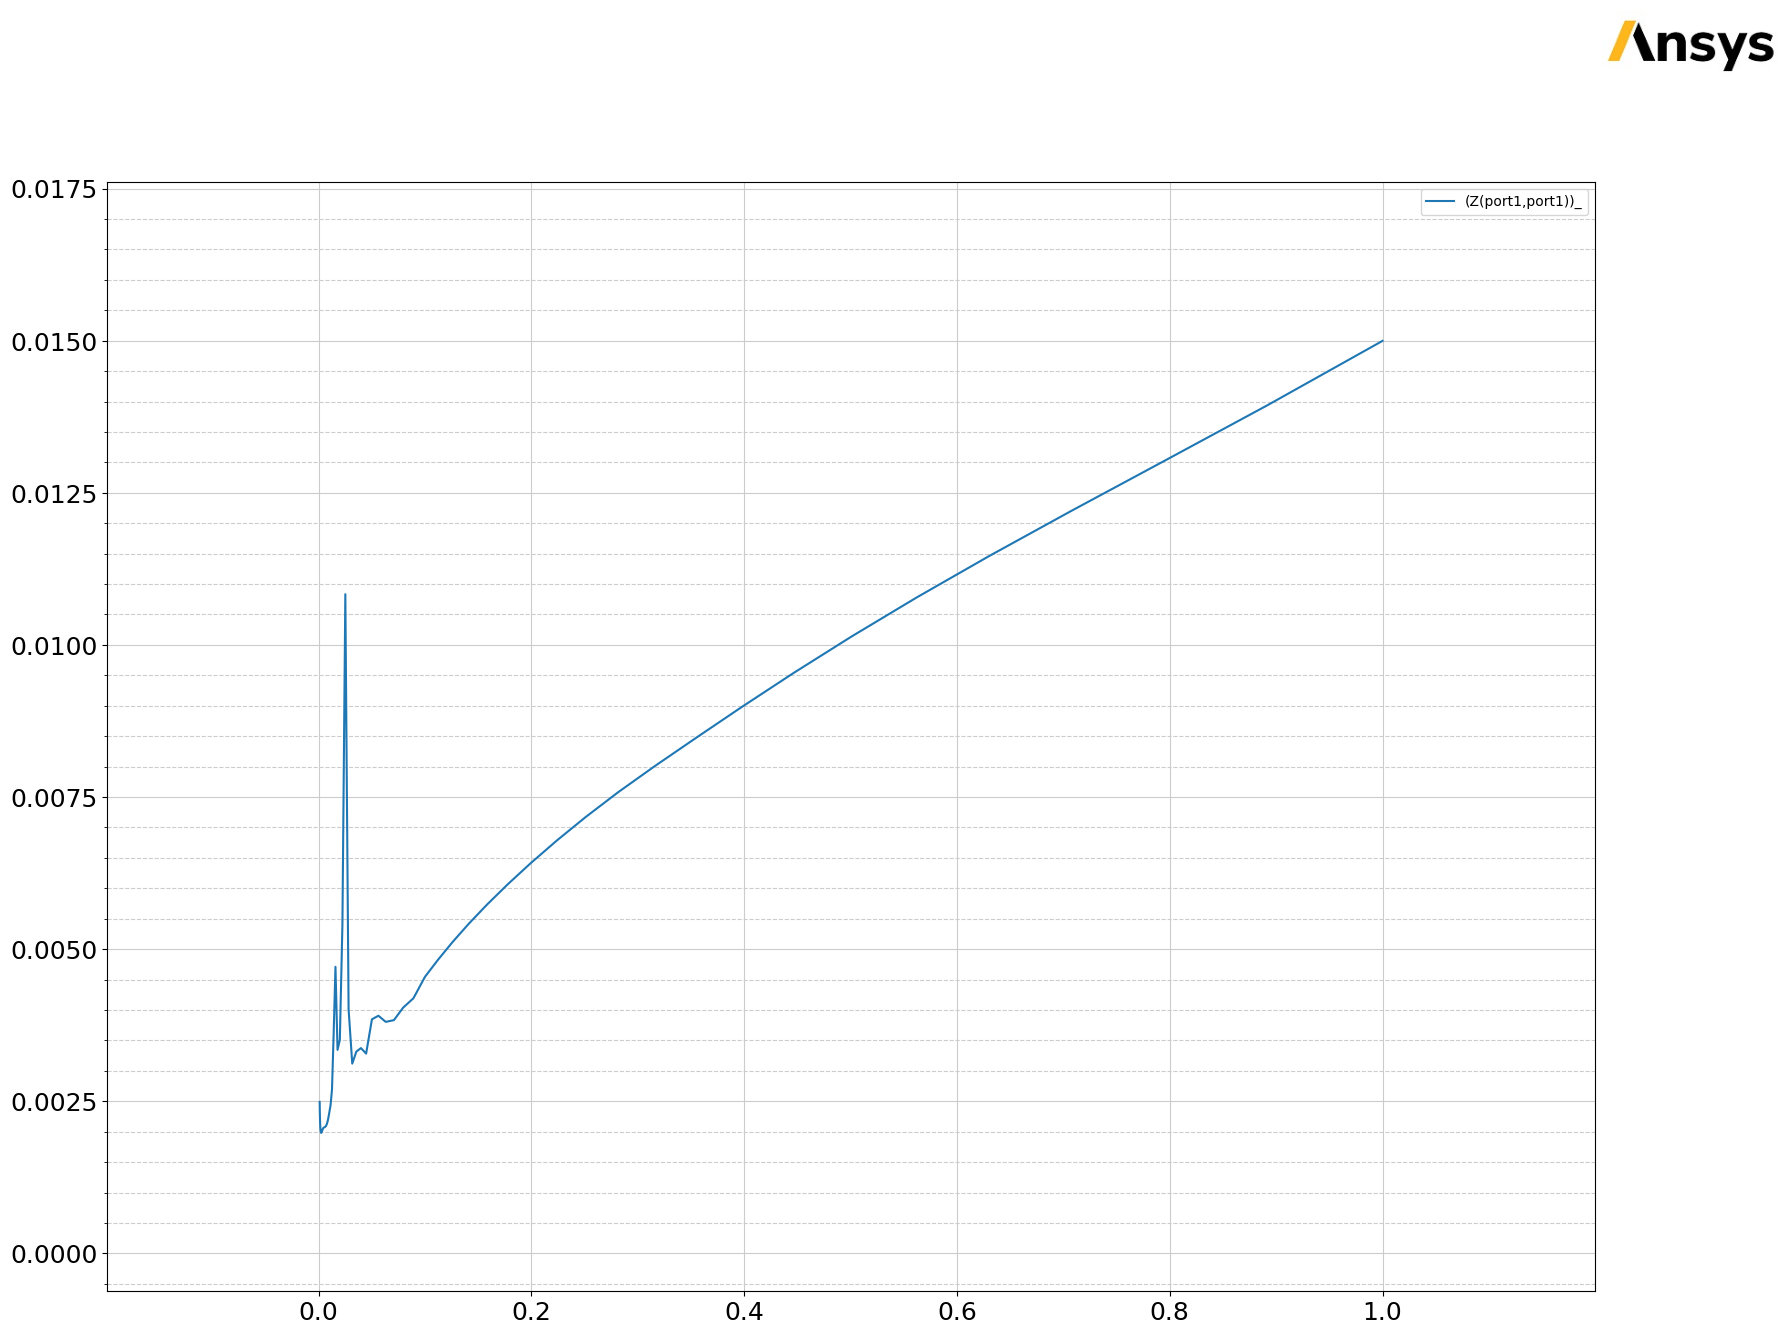

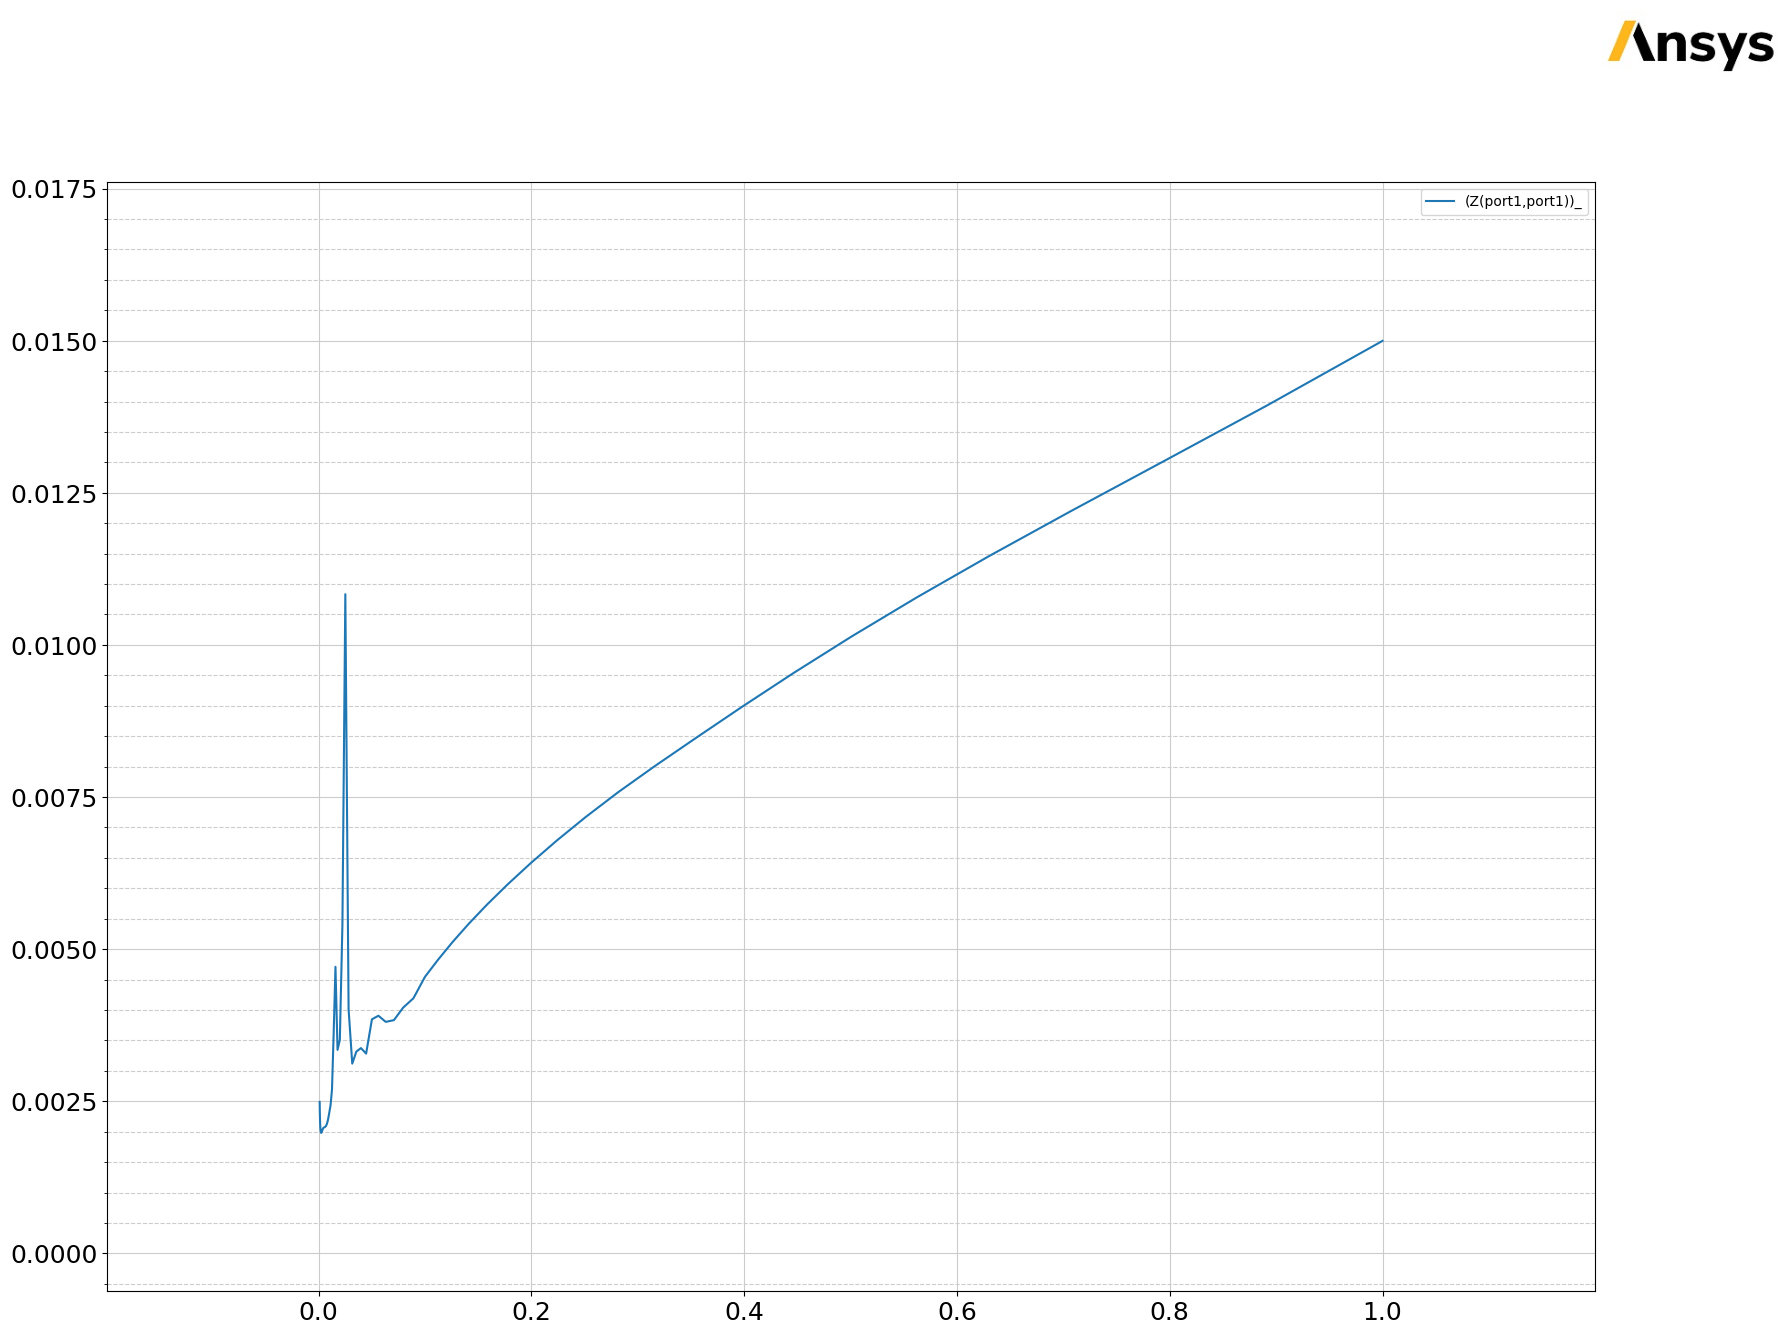

In [17]:
solutions = h3d.post.get_solution_data(expressions="Z(port1,port1)")
solutions.plot()

## Release AEDT

In [18]:
h3d.save_project()
h3d.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project ANSYS-HSD_V1 Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell
removes all temporary files, including the project folder.

In [19]:
temp_folder.cleanup()